## Predicting Anime Ratings with Spark
A quick example of spark & pandas, using Mllib.

The dataset was taken from Kaggle.

In [1]:
import findspark
findspark.init('/home/max/Downloads/spark-2.1.1-bin-hadoop2.7')

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as seas

sc = SparkContext() # start the spark context
spark = SparkSession(sc) # start spark session

### Dataset

A bunch of anime titles, their genre, whether they are TV or Movie, their # of episodes, rating and number of members in that group

In [59]:
# import the data - use pandas, then convert to spark dataframe after preprocessing
dat = pd.read_csv('anime.csv')

# remove "nan" data
dat = dat.dropna().reset_index(drop=True)

# lets see what this looks like:
dat.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


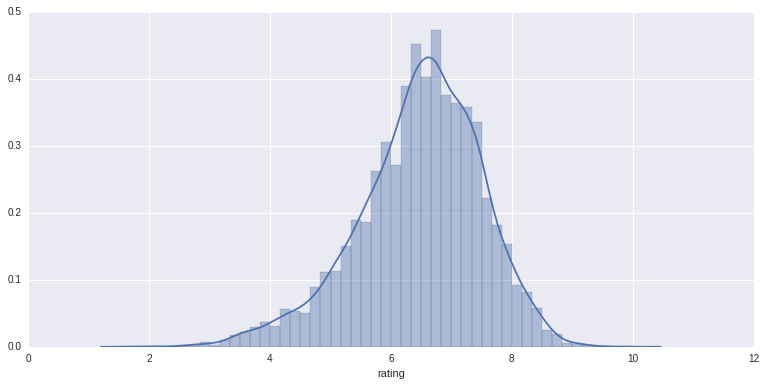

In [60]:
%matplotlib inline
import math
## Ratings look like this:
ratings = dat[dat['rating'].apply(lambda x: math.isnan(x) == False)]['rating']

# graphing
seas.set(rc={"figure.figsize": (13, 6)})
seas.distplot(ratings) 

### Preprocessing
Turn categorical data into binary vectors.
The categorical data is "genre" and "type"

In [61]:
N = len(dat) # number of samples

### get all the genres:
genres = []  # store all genres here:
for i in range(N):
    # split the string into array
    tmp = str(dat['genre'][i]).split()
    for j in range(len(tmp)):
        if tmp[j].replace(',','') != genres:
            # add new genre to the list
            genres.append(tmp[j].replace(',',''))
# sort the array & show
genres = np.sort(np.unique(genres))
print(genres)

#create a lookup table to refer to later:
gn_lut = {g: i for i,g in enumerate(genres)}

['Action' 'Adventure' 'Ai' 'Arts' 'Cars' 'Comedy' 'Dementia' 'Demons'
 'Drama' 'Ecchi' 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror'
 'Josei' 'Kids' 'Life' 'Magic' 'Martial' 'Mecha' 'Military' 'Music'
 'Mystery' 'Parody' 'Police' 'Power' 'Psychological' 'Romance' 'Samurai'
 'School' 'Sci-Fi' 'Seinen' 'Shoujo' 'Shounen' 'Slice' 'Space' 'Sports'
 'Super' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri' 'of']


In [62]:
### get all of the episode names
types = np.unique(dat['type'].tolist()).tolist()
print(types)
# lookup table
typ_lut = {t: i for i,t in enumerate(types)}

['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV']


In [63]:
### for each sample encode their values in matrices
a_genre = np.zeros((N,len(genres)))
a_type = np.zeros((N,len(types)))

for i in range(N):
    # get the genre first:
    tmp = str(dat['genre'][i]).split()
    for j in range(len(tmp)):
        a_genre[i,gn_lut[tmp[j].replace(',','')]] = 1. 
    # get the type:
    a_type[i,typ_lut[str(dat['type'][i])]] = 1.
       

In [68]:
### send back to pd dataframe:
newdat = pd.DataFrame(a_genre)
newdat = pd.concat((dat.ix[:,[1,4,5,6]],newdat,pd.DataFrame(a_type)),axis = 1)
# rename columns:
newdat.columns = ['name','episodes','rating','members'] + [i for i in range(np.shape(newdat)[1]-4)]
newdat = newdat.dropna().reset_index(drop=True)
newdat.head(5)

,name,episodes,rating,members,0,1,2,3,4,5,...,42,43,44,45,46,47,48,49,50,51
0,Kimi no Na wa.,1,9.37,200630,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Fullmetal Alchemist: Brotherhood,64,9.26,793665,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Gintama°,51,9.25,114262,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Steins;Gate,24,9.17,673572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Gintama&#039;,51,9.16,151266,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Import to spark & Do some machine learning
Going to use a ridge regression to predict the rating of an anime given some features...

In [69]:
anime = spark.createDataFrame(newdat)
print(anime.take(1))

[Row(name='Kimi no Na wa.', episodes='1', rating=9.37, members=200630, 0=0.0, 1=0.0, 2=0.0, 3=0.0, 4=0.0, 5=0.0, 6=0.0, 7=0.0, 8=1.0, 9=0.0, 10=0.0, 11=0.0, 12=0.0, 13=0.0, 14=0.0, 15=0.0, 16=0.0, 17=0.0, 18=0.0, 19=0.0, 20=0.0, 21=0.0, 22=0.0, 23=0.0, 24=0.0, 25=0.0, 26=0.0, 27=0.0, 28=0.0, 29=1.0, 30=0.0, 31=1.0, 32=0.0, 33=0.0, 34=0.0, 35=0.0, 36=0.0, 37=0.0, 38=0.0, 39=0.0, 40=1.0, 41=0.0, 42=0.0, 43=0.0, 44=0.0, 45=0.0, 46=1.0, 47=0.0, 48=0.0, 49=0.0, 50=0.0, 51=0.0)]


In [70]:
from pyspark.mllib.regression import LabeledPoint, RidgeRegressionWithSGD
from pyspark.sql import Row

In [71]:
def make_feat(x):
    # label the points
    return LabeledPoint(x['rating'],x[3:])

# split data into test and train portions
tst,trn = anime.randomSplit([0.3,0.7])
train = trn.rdd.map(make_feat)
test = tst.rdd.map(make_feat)
del tst, trn

In [72]:
# show what the features look like as a dataframe:
train.toDF().show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[18013.0,0.0,0.0,...| 7.54|
|[40984.0,0.0,0.0,...| 7.63|
|[11617.0,1.0,1.0,...| 7.32|
|[4311.0,1.0,1.0,0...| 7.33|
|[59492.0,0.0,0.0,...| 7.93|
|[3963.0,0.0,0.0,0...| 7.14|
|[8892.0,1.0,1.0,0...| 7.13|
|[140604.0,1.0,0.0...| 7.93|
|[22302.0,0.0,0.0,...| 7.84|
|[34590.0,0.0,0.0,...| 7.41|
|[12872.0,0.0,0.0,...| 7.45|
|[96694.0,0.0,0.0,...| 7.45|
|[19257.0,0.0,0.0,...| 7.61|
|[29330.0,0.0,0.0,...| 7.65|
|[18465.0,0.0,0.0,...| 7.71|
|[324284.0,1.0,0.0...| 7.62|
|[61198.0,1.0,0.0,...| 7.32|
|[3433.0,0.0,0.0,0...| 7.59|
|[127973.0,0.0,0.0...| 7.65|
|[26246.0,0.0,0.0,...| 7.62|
+--------------------+-----+
only showing top 20 rows



In [80]:
## Build the model
model = RidgeRegressionWithSGD.train(train, step = 0.001)

/home/max/Downloads/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/regression.py:567: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 0.0. Note the default regParam is 0.01 for RidgeRegressionWithSGD, but is 0.0 for LinearRegression.
  "Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 0.0. "


In [81]:
predictions = model.predict(test)
labels_and_preds = test.map(lambda lp: (lp.label,model.predict(lp.features)) )